In [8]:
from pandas import Timedelta, to_datetime
from matplotlib.pyplot import subplots, savefig, show, legend, close
from pandas import read_csv, read_parquet
from glob import glob
from collections import defaultdict
from pandas import Series
from tqdm.auto import tqdm
from plotly.subplots import make_subplots
from plotly.graph_objects import Figure, Scatter
from random import choice as choose_randomly
from pandas import Timestamp
from pandas.core.indexes.base import Index
from tqdm.notebook import tqdm
from pandas import DataFrame, IndexSlice
from gc import collect as garbage_collect

subset_data: bool = False


def make_biometrics_plots_together_matplotlib(
    data: defaultdict[str, defaultdict[str, defaultdict[str, Series]]],
    user_id: str,
    session_id: str,
    dataset: str,
    experiment_info: DataFrame,
    **kwargs,
) -> None:
    data = {key: val for key, val in data.items() if val is not None}
    fig, axs = subplots(
        len(data.keys()), 1, figsize=(14, 11 * len(data.keys())), sharex=True
    )
    if len(data.keys()) == 1:
        axs = [axs]
    
    for n, (data_type, physiological_data) in tqdm(
        enumerate(data.items()), desc="Plotting data", total=len(data.keys())
    ):
        if physiological_data is None:
            continue

        for side, specific_side_data in physiological_data.items():
            user_data: DataFrame = specific_side_data[user_id]

            if data_type == "EDA":
                eda_type: str = kwargs["eda_type"]
                data_to_plot = user_data[eda_type]
            else:
                data_to_plot = user_data.iloc[:, 0]

            data_to_plot = data_to_plot.loc[IndexSlice[session_id, :]]
            if subset_data:
                data_to_plot = data_to_plot[:1000]

            data_to_plot.index = to_datetime(data_to_plot.index)
            axs[n].plot(
                data_to_plot.index,
                data_to_plot.values,
                label=side,
                linestyle="-",
            )
            axs[n].set_title(data_type)

            # del data_to_plot
            # garbage_collect()

        # session_id_corrected: Timestamp = to_datetime(
        #     session_ids["left"].split("-")[0], format="%y%m%d"
        # )  + Timedelta("1D")
        # session_id_corrected: str = str(session_id_corrected.date())
        if dataset == "mwc2022":
            start_exp = Timestamp(
                experiment_info.loc[IndexSlice[user_id, session_id], "actual_bed_time"]
            )
            end_exp = Timestamp(
                experiment_info.loc[IndexSlice[user_id, session_id], "wake_up_time"]
            )
            # start_exp = start_exp.tz_localize("Europe/Rome")
            # end_exp = end_exp.tz_localize("Europe/Rome")

            axs[n].axvspan(
                xmin=start_exp,
                xmax=end_exp,
                color="#828282",
                alpha=0.3,
                label="sleep time",
            )
            axs[n].set_ylabel(f"Time")
            axs[n].set_ylabel(f"{data_type}")
        elif dataset == "usi_laughs":
            events = set(
                ["_".join(col.split("_")[1:]) for col in experiment_info.columns]
            )
            for i, event in enumerate(events):
                start_exp = Timestamp(experiment_info.loc[user_id, f"start_{event}"])
                end_exp = Timestamp(experiment_info.loc[user_id, f"end_{event}"])
                if "baseline" in event and i == 0:
                    label = "baseline"
                elif "baseline" not in event:
                    label = event
                else:
                    label = None

                axs[n].axvspan(
                    xmin=start_exp,
                    xmax=end_exp,
                    color="#828282" if "baseline" in event else "#548572",
                    alpha=0.3,
                    label=label,
                )
                axs[n].set_ylabel(f"Time")
                axs[n].set_ylabel(f"{data_type}")
        else:
            raise ValueError(
                f"Received as dataset {dataset}, but only mwc2022 and usi_laughs are supported"
            )

    handles, labels = axs[-1].get_legend_handles_labels()
    fig.legend(
        handles,
        labels,
        fontsize="x-large",
        title="Side",
        title_fontsize="xx-large",
        #    loc='best'
    )
    # legend()
    fig.suptitle(
        f"Plots for all singals for user {user_id}, session {session_id}",
        fontsize=30,
        y=0.97,
    )
    savefig(f"../visualizations/{dataset}_{user_id}_{session_id}.pdf")
    # show()
    close()

    return start_exp, end_exp


# Intro

This notebook is intended to provide data exploration for all datasets concerning this Lateralization study. As the moment, the datasets impemented are:
* USILaughs
* MWC2022 study

I split the same notebook into 2, since I was having problems w/ remote working, due too large filesizes.

# MWC 2022

## Sleep Info

For the moment, I shall consider the self-reports for the sleep data.

In [9]:
from pandas import read_csv, to_datetime

In [10]:
experiment_info = read_csv('../data.nosync/mwc2022/all_experimento_info.csv', index_col=[0,1])
experiment_info['actual_bed_time'] = experiment_info['actual_bed_time'].apply(to_datetime)
experiment_info['wake_up_time'] = experiment_info['wake_up_time'].apply(to_datetime)
experiment_info['actual_bed_time'] = experiment_info['actual_bed_time'].dt.tz_localize('Europe/Rome')
experiment_info['wake_up_time'] = experiment_info['wake_up_time'].dt.tz_localize('Europe/Rome')

In [11]:
experiment_info[experiment_info['actual_bed_time'] < experiment_info['wake_up_time']]

index             bed_time latency  \
participant_id Date                                             
U09            2022-11-20    239  2022-11-20 01:45:00      15   
               2022-11-18    235  2022-11-18 00:15:00      15   
               2022-11-27    253  2022-11-27 03:05:00      10   
               2022-11-28    255  2022-11-28 00:33:00      21   
               2022-11-19    237  2022-11-19 00:55:00       5   
...                          ...                  ...     ...   
U10            2022-12-16    340  2022-12-16 00:30:59     5.0   
               2022-11-30    148  2022-11-30 00:28:00      10   
               2022-12-17    341  2022-12-17 00:40:58     5.0   
               2022-12-19    343  2022-12-19 00:32:54     3.0   
               2022-12-21    345  2022-12-21 03:00:17     0.0   

                                       wake_up_time awakening  \
participant_id Date                                             
U09            2022-11-20 2022-11-20 08:45:00+01:00         1   
               2022-11-18 2022-11-18 07:38:00+01:00         2   
               2022-11-27 2022-11-27 09:43:00+01:00         0   
               2022-11-28 2022-11-28 08:08:00+01:00         0   
               2022-11-19 2022-11-19 09:03:00+01:00         0   
...                                             ...       ...   
U10            2022-12-16 2022-12-16 08:18:13+01:00       3.0   
               2022-11-30 2022-11-30 07:06:00+01:00         2   
               2022-12-17 2022-12-17 08:20:10+01:00       0.0   
               2022-12-19 2022-12-19 06:40:08+01:00       0.0   
               2022-12-21 2022-12-21 07:34:36+01:00       0.0   

                          awakening_duration  \
participant_id Date                            
U09            2022-11-20                  2   
               2022-11-18                  2   
               2022-11-27                  0   
               2022-11-28                  0   
               2022-11-19                  0   
...                                      ...   
U10            2022-12-16           00:15:00   
               2022-11-30                NaN   
               2022-12-17           00:00:00   
               2022-12-19           00:00:00   
               2022-12-21           00:00:00   

                                                         disturbance_reasons  \
participant_id Date                                                            
U09            2022-11-20                                                NaN   
               2022-11-18                                feeling too hot (2)   
               2022-11-27                                                NaN   
               2022-11-28                                                NaN   
               2022-11-19                                                NaN   
...                                                                      ...   
U10            2022-12-16  My cat wanted to get outside so I had to open ...   
               2022-11-30                                                NaN   
               2022-12-17                                                  -   
               2022-12-19                                                  -   
               2022-12-21                                                  -   

                           recovery  sleep_quality morning_comments  \
participant_id Date                                                   
U09            2022-11-20       6.0            6.0              NaN   
               2022-11-18       7.0            8.0              NaN   
               2022-11-27       6.0            6.0              NaN   
               2022-11-28       7.0            7.0              NaN   
               2022-11-19       5.0            8.0              NaN   
...                             ...            ...              ...   
U10            2022-12-16       6.0            4.0                -   
               2022-11-30     

## Physiological Data

In [12]:
from pandas import read_csv, read_parquet
from glob import glob
from collections import defaultdict
from pandas import Series
from tqdm.auto import tqdm
from plotly.subplots import make_subplots
from plotly.graph_objects import Figure, Scatter
from random import choice as choose_randomly
from pandas import Timestamp
from pandas.core.indexes.base import Index
from tqdm.notebook import tqdm
from pandas import DataFrame, IndexSlice
from gc import collect as garbage_collect

eda_data_base_path: str = "../data.nosync/mwc2022/filtered/*/EDA/*.parquet"
# acc_data_base_path: str = "../data.nosync/mwc2022/filtered/*/ACC/*.parquet"

eda_data_paths: list[str] = glob(eda_data_base_path)
# acc_data_paths: list[str] = glob(acc_data_base_path)
eda_data: defaultdict[str, defaultdict[str, Series]] = defaultdict(
    lambda: defaultdict()
)
for file in tqdm(eda_data_paths, desc="Loading EDA data"):
    side_name = file.split("/")[-3]
    user_name = file.split("/")[-1].split(".")[0]
    eda_data[side_name][user_name] = read_parquet(file)
    
   
# acc_data: defaultdict[str, defaultdict[str, Series]] = defaultdict(
#     lambda: defaultdict()
# ) 
# for file in tqdm(acc_data_paths, desc="Loading ACC data"):
#     side_name = file.split("/")[-3]
#     user_name = file.split("/")[-1].split(".")[0]
#     acc_data[side_name][user_name] = read_parquet(file)

acc_data = None
bvp_data = None

# bvp_data_base_path: str = "../data/filtered/*/BVP/*.parquet"
# bvp_data_paths: list[str] = glob(bvp_data_base_path)
# bvp_data: defaultdict[str, defaultdict[str, Series]] = defaultdict(
#     lambda: defaultdict()
# )
# for file in tqdm(bvp_data_paths, desc="Loading BVP data"):
#     side_name = file.split("/")[-3]
#     user_name = file.split("/")[-1].split(".")[0]
#     bvp_data[side_name][user_name] = read_parquet(file)
    
    
physiological_data: dict[str, defaultdict[str, defaultdict[str, Series]]] = {
    "EDA": eda_data,
    "BVP": bvp_data,
    'ACC': acc_data,
}
del eda_data
del bvp_data
del acc_data
garbage_collect()

Loading EDA data:   0%|          | 0/19 [00:00<?, ?it/s]

330

In [13]:
users_left = physiological_data["EDA"]["left"].keys()
users_right = physiological_data["EDA"]["right"].keys()
users = list(set(users_left) & set(users_right))
sessions_all = ['experiment']

In [14]:
users_in_left_side = set(physiological_data['EDA']['left'].keys())
users_in_right_side = set(physiological_data['EDA']['right'].keys())

In [15]:
print(f"Number of users with both left and right hand data: {len(users_in_left_side & users_in_right_side)}")

Number of users with both left and right hand data: 8


## Segmentation

The segmentation will be performed over `baseline_1` and `cognitive_load` periods. Other baselines are not considered, since they were very short periods performed after some activity, one of which was cognitive load itself. As such, brian phenomena from those activites might propagate in the EDA signal and make the classification harded.

In [16]:
def remove_usr_from_idx(df: DataFrame, key: str) -> DataFrame:
    df = df.loc[IndexSlice[key, :], :]
    df.index = df.index.droplevel(0)
    return df
    
experiment_info_as_dict = {participant: remove_usr_from_idx(df=experiment_info, key=participant)
                           for participant in list(experiment_info.index.get_level_values(0).unique())}

In [17]:
segment_size_in_mins = 10
segment_size_in_secs = segment_size_in_mins * 60
eda_sample_rate = 4
segment_size_in_sampling_rate: int = segment_size_in_secs * eda_sample_rate

In [18]:
eda_data = physiological_data['EDA']

In [19]:
# user = "U13"
# info = experiment_info_as_dict[user]
# data = eda_data['left'][user]

In [20]:
users = list(set(eda_data["left"].keys()) & set(eda_data["right"].keys()))

In [21]:
from numpy import nan, ndarray
from pandas import Timedelta


def get_session_moment(start: Timestamp, end: Timestamp, info: Series) -> int | float:
    # this method gives 0 if the person is awake and 1 if the person is
    if (start < info["actual_bed_time"] and end < info["actual_bed_time"]) or (
        start > info["wake_up_time"] and end > info["wake_up_time"]
    ):
        return 0
    elif (start < info["actual_bed_time"] and end > info["actual_bed_time"]) or (
        start < info["wake_up_time"] and end > info["wake_up_time"]
    ):
        return nan
    else:
        return 1


data_segmented_left: list[tuple] = []
data_segmented_right: list[tuple] = []
users = list(set(eda_data["left"].keys()) & set(eda_data["right"].keys()))

for user in users:
    data_left = eda_data["left"][user]
    data_right = eda_data["right"][user]
    info = experiment_info_as_dict[user]
    sessions = list(
        set(data_left.index.get_level_values(0).unique())
        & set(data_right.index.get_level_values(0).unique())
    )
    morning_survey_sessions = (
        experiment_info.loc[IndexSlice[user, :], :].index.get_level_values(1).unique()
    )

    sessions_all = list(set(sessions) & set(morning_survey_sessions))

    for session in tqdm(sessions_all, desc=f"Splitting {user=}. Sessions progress:"):
        session_data_left: DataFrame = data_left.loc[IndexSlice[session, :], :]
        session_data_right: DataFrame = data_right.loc[IndexSlice[session, :], :]

        session_info = info.loc[session, :]

        starts_left = session_data_left[
            ::segment_size_in_sampling_rate
        ].index.get_level_values(1)
        starts_right = session_data_right[
            ::segment_size_in_sampling_rate
        ].index.get_level_values(1)

        ends_left = (
            session_data_left[::segment_size_in_sampling_rate].index.get_level_values(1)
            + Timedelta(f"{segment_size_in_mins}min")
            - Timedelta(f"{1/eda_sample_rate}s")
        )
        ends_right = (
            session_data_right[::segment_size_in_sampling_rate].index.get_level_values(
                1
            )
            + Timedelta(f"{segment_size_in_mins}min")
            - Timedelta(f"{1/eda_sample_rate}s")
        )

        segments_left = [
            (
                session_data_left.loc[
                    IndexSlice[session, start:end],
                    "mixed-EDA",
                ].values,
                get_session_moment(start, end, session_info),
                user,
            )
            for start, end in zip(starts_left, ends_left)
        ]
        segments_right = [
            (
                session_data_right.loc[
                    IndexSlice[session, start:end],
                    "mixed-EDA",
                ].values,
                get_session_moment(start, end, session_info),
                user,
            )
            for start, end in zip(starts_right, ends_right)
        ]
        data_segmented_left.append(segments_left)
        data_segmented_right.append(segments_right)


Splitting user='U01'. Sessions progress::   0%|          | 0/10 [00:00<?, ?it/s]

Splitting user='U04'. Sessions progress::   0%|          | 0/11 [00:00<?, ?it/s]

Splitting user='U06'. Sessions progress::   0%|          | 0/5 [00:00<?, ?it/s]

Splitting user='U09'. Sessions progress::   0%|          | 0/19 [00:00<?, ?it/s]

Splitting user='U03'. Sessions progress::   0%|          | 0/16 [00:00<?, ?it/s]

Splitting user='U10'. Sessions progress::   0%|          | 0/7 [00:00<?, ?it/s]

Splitting user='U02'. Sessions progress:: 0it [00:00, ?it/s]

Splitting user='U13'. Sessions progress::   0%|          | 0/33 [00:00<?, ?it/s]

In [22]:
from numpy import isnan
values_left = [
    val[0]
    for segments in data_segmented_left
    for val in segments
    if not isnan(val[1])
]
values_right = [
    val[0]
    for segments in data_segmented_right
    for val in segments
    if not isnan(val[1])
]

labels_left = [
    val[1]
    for segments in data_segmented_left
    for val in segments
    if not isnan(val[1])
]
labels_right = [
    val[1]
    for segments in data_segmented_right
    for val in segments
    if not isnan(val[1])
]

groups_left = [
    val[2]
    for segments in data_segmented_left
    for val in segments
    if not isnan(val[1])
]

groups_right = [
    val[2]
    for segments in data_segmented_right
    for val in segments
    if not isnan(val[1])
]

1    4088
0    1015
dtype: int64
1    80.10974
0    19.89026
dtype: float64


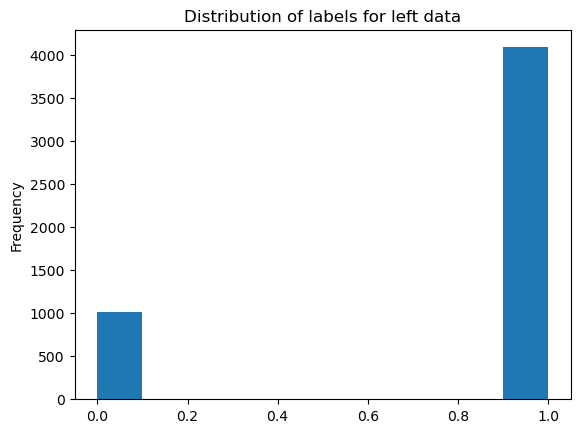

In [23]:
import matplotlib.pyplot as plt

Series(labels_left).plot(kind="hist")
plt.title('Distribution of labels for left data')
print(Series(labels_left).value_counts())
print(Series(labels_left).value_counts()/Series(labels_left).count()*100)

1    4144
0    1023
dtype: int64
1    80.20128
0    19.79872
dtype: float64


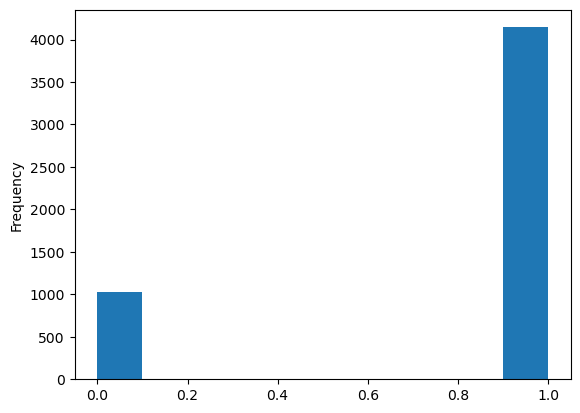

In [24]:
Series(labels_right).plot(kind="hist")
print(Series(labels_right).value_counts())
print(Series(labels_right).value_counts()/Series(labels_right).count()*100)

The distribution is almost balanced: as such, re-balancing should not be a large problem.

## Feature Extraction

In [25]:
from sys import path
path.append("../")
from joblib import Parallel, delayed
from src.feature_extraction.eda import get_eda_features
from numpy import stack

features_left = Parallel(n_jobs=-1)(delayed(get_eda_features)(value) for value in (values_left))
features_right = Parallel(n_jobs=-1)(delayed(get_eda_features)(value) for value in (values_right))

features_left: ndarray = stack(features_left)
features_right: ndarray = stack(features_right)

labels_left: ndarray = stack(labels_left)
labels_right: ndarray = stack(labels_right)

groups_left: ndarray = stack(groups_left)
groups_right: ndarray = stack(groups_right)

/Users/leonardoalchieri/miniconda3/envs/laugh/lib/python3.10/site-packages/neurokit2/eda/eda_peaks.py:130: RuntimeWarning: All-NaN slice encountered
  info["SCR_Peaks"] > np.nanmin(info["SCR_Onsets"]), ~np.isnan(info["SCR_Onsets"])
/Users/leonardoalchieri/miniconda3/envs/laugh/lib/python3.10/site-packages/neurokit2/eda/eda_peaks.py:130: RuntimeWarning: All-NaN slice encountered
  info["SCR_Peaks"] > np.nanmin(info["SCR_Onsets"]), ~np.isnan(info["SCR_Onsets"])
Could not extract EDA peaks. Reason: zero-size array to reduction operation maximum which has no identity
Could not extract EDA peaks. Reason: zero-size array to reduction operation maximum which has no identity
Could not extract EDA peaks. Reason: zero-size array to reduction operation maximum which has no identity
Could not extract EDA peaks. Reason: zero-size array to reduction operation maximum which has no identity
Could not extract EDA peaks. Reason: zero-size array to reduction operation maximum which has no identity
Could 

In [27]:
print(f"{features_left.shape=}")
print(f"{labels_left.shape=}")
print(f"{groups_left.shape=}")

features_left.shape=(5103, 11)
labels_left.shape=(5103,)
groups_left.shape=(5103,)


# Cliff Delta

In [28]:
from effect_size_analysis.cliff_delta import cliff_delta

from pandas import Series
from numpy import isnan, nan, sign

def get_cliff_bin(x: Series, dull: list[str] | None = None, raise_nan: bool = False) -> str:
    x_sign = sign(x)
    x = abs(x)
    if dull is None:
        dull: dict[str, str] = {'small': 0.11, 'medium': 0.28, 'large': 0.43} # effect sizes from (Vargha and Delaney (2000)) "negligible" for the rest=
    if x < dull['small']:
        return 0*x_sign
    elif dull['small'] <= x < dull['medium']:
        return 1*x_sign
    elif dull['medium'] <= x < dull['large']:
        return 2*x_sign
    elif x >= dull['large']:
        return 3*x_sign
    else:
        if isnan(x):
            if raise_nan:
                raise ValueError("NaN value")
            else:
                return nan
        else:
            raise ValueError(f"{x} is not in the dull range")

In [29]:
cognitive_load_data_left = features_left[labels_left == 1]
baseline_data_left = features_left[labels_left == 0]

cognitive_load_data_right = features_right[labels_right == 1]
baseline_data_right = features_right[labels_right == 0]

In [30]:
eda_features = [
    "min_feat",
    "max_feat",
    "mean_feat",
    "std_feat",
    "dynamic_range_feat",
    "slope_feat",
    "absolute_slope_feat",
    "first_derivetive_mean_feat",
    "first_derivative_std_feat",
    "number_of_peaks_feat",
    "peaks_amplitude_feat",
]

In [31]:
alpha = 0.05

cliff_delta_cognitive_load = {}
for i, feature in enumerate(eda_features):
    cliff_delta_cognitive_load[feature] = Series(
        cliff_delta(
            s1=cognitive_load_data_left[:, i],
            s2=cognitive_load_data_right[:, i],
            alpha=alpha,
            accurate_ci=True,
            raise_nan=False,
        ),
        index=['value', 'confidence interval']
        )

cliff_delta_baseline = {}
for i, feature in enumerate(eda_features):
    cliff_delta_baseline[feature] = Series(cliff_delta(
            s1=baseline_data_left[:,i],
            s2=baseline_data_right[:,i],
            alpha=alpha,
            accurate_ci=True,
            raise_nan=False,
        ), index=['value', 'confidence interval'])

In [32]:
cliff_delta_cognitive_load = DataFrame(cliff_delta_cognitive_load)
cliff_delta_baseline = DataFrame(cliff_delta_baseline)
# DataFrame([cliff_delta_cognitive_load, cliff_delta_baseline], index=["cognitive_load", "baseline"])

In [33]:
from pandas import concat

d = {'Cognitive Load' : cliff_delta_cognitive_load, 'Baseline' : cliff_delta_baseline}
cliff_deltas = concat(d.values(), axis=0, keys=d.keys())

In [34]:
cliff_deltas_values = cliff_deltas.loc[IndexSlice[:, 'value'], :]
cliff_deltas_values = cliff_deltas_values.droplevel(level=1, axis=0)
cliff_delta_bins = cliff_deltas_values.applymap(get_cliff_bin)

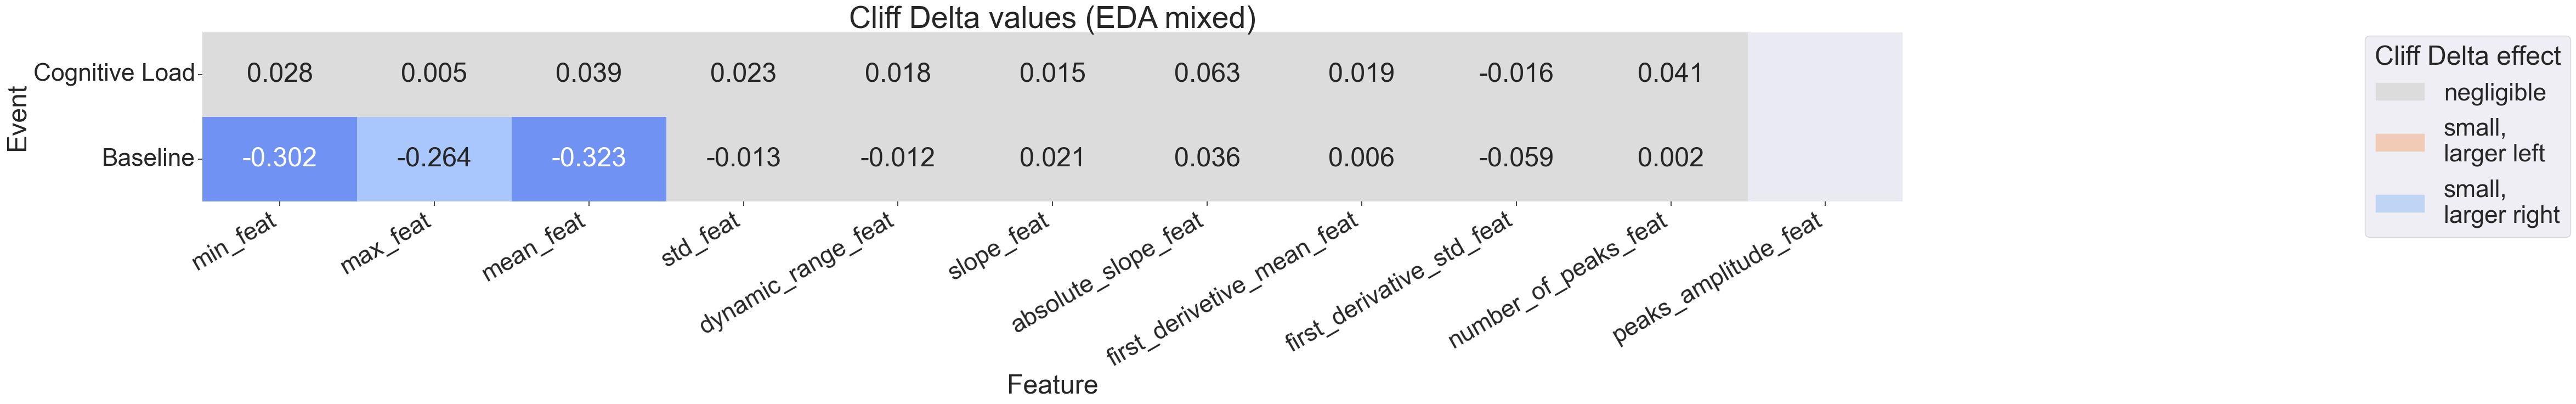

In [37]:
from matplotlib.pyplot import xticks, xlabel, ylabel, legend, cm, figure, title
from matplotlib.patches import Patch
from seaborn import set, heatmap


cmap = cm.coolwarm
set(font_scale=2.9)
figure(figsize=(40, 4))
ax = heatmap(cliff_delta_bins, 
        xticklabels=cliff_deltas_values.columns,
        vmax=3, vmin=-3, center=0,
        annot=cliff_deltas_values.astype(float).round(decimals=3),
        cmap=cmap,
        fmt='',
        cbar=False,
        yticklabels=cliff_deltas_values.index)
ax.tick_params(left=True, bottom=True)
xticks(rotation=30, ha='right')
xlabel('Feature')
ylabel('Event')
title(
    "Cliff Delta values (EDA mixed)", fontsize=40
)

custom_handles = [Patch(facecolor=cmap(0.5), edgecolor=cmap(0.5), label='negligible'),
                Patch(facecolor=cmap(0.6), edgecolor=cmap(0.6), label='small,\nlarger left'),
                Patch(facecolor=cmap(0.4), edgecolor=cmap(0.4), label='small,\nlarger right')]
legend(handles=custom_handles, bbox_to_anchor=(1.4, 1.05), title='Cliff Delta effect')
# savefig("../visualizations/cliff_delta_confrontations_eda.pdf",  bbox_inches='tight')
show()

In [38]:
cliff_deltas_values = cliff_deltas.loc[IndexSlice[:, 'confidence interval'], :].applymap(lambda x: x[-1])
cliff_deltas_values = cliff_deltas_values.droplevel(level=1, axis=0)
cliff_delta_bins = cliff_deltas_values.applymap(get_cliff_bin)

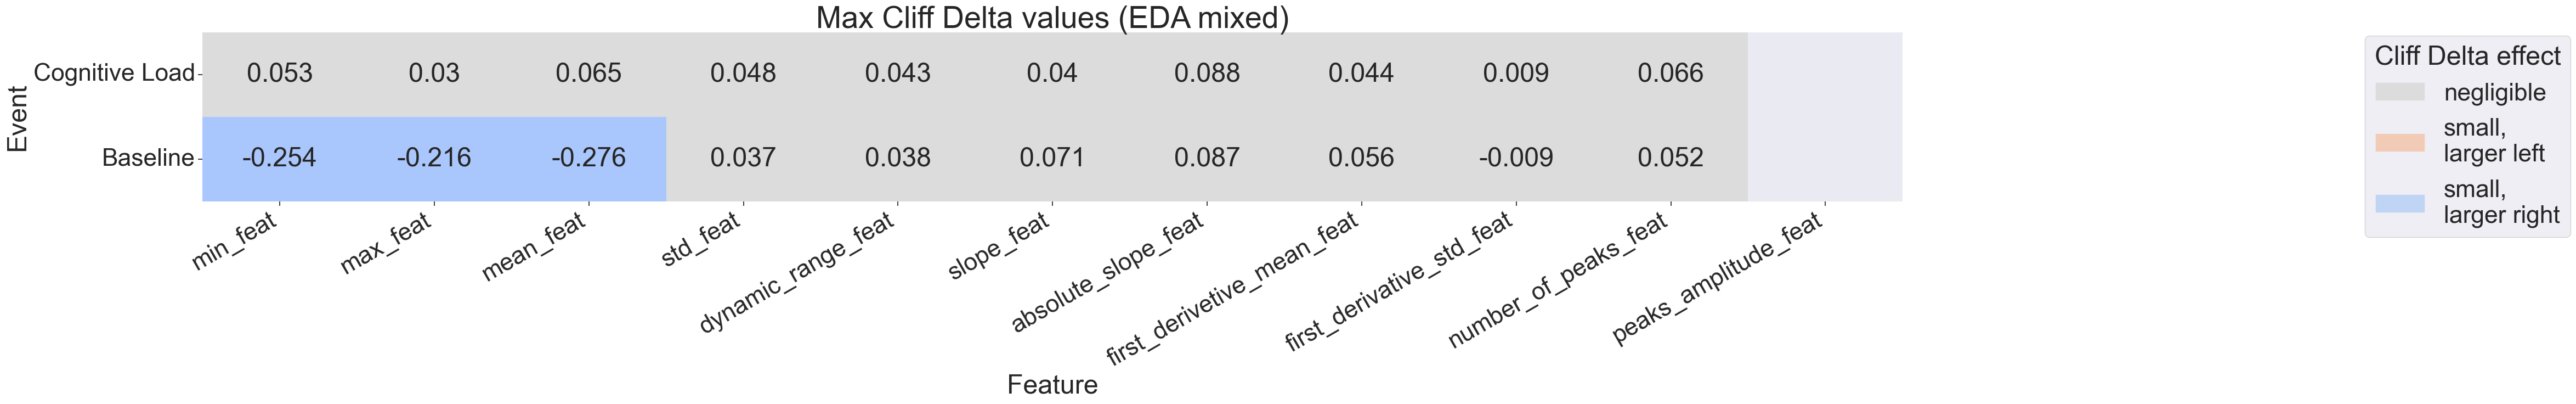

In [39]:
from matplotlib.pyplot import xticks, xlabel, ylabel, legend, cm, figure, title
from matplotlib.patches import Patch
from seaborn import set, heatmap


cmap = cm.coolwarm
set(font_scale=2.9)
figure(figsize=(40, 4))
ax = heatmap(cliff_delta_bins, 
        xticklabels=cliff_deltas_values.columns,
        vmax=3, vmin=-3, center=0,
        annot=cliff_deltas_values.astype(float).round(decimals=3),
        cmap=cmap,
        fmt='',
        cbar=False,
        yticklabels=cliff_deltas_values.index)
ax.tick_params(left=True, bottom=True)
xticks(rotation=30, ha='right')
xlabel('Feature')
ylabel('Event')
title(
    "Max Cliff Delta values (EDA mixed)", fontsize=40
)

custom_handles = [Patch(facecolor=cmap(0.5), edgecolor=cmap(0.5), label='negligible'),
                Patch(facecolor=cmap(0.6), edgecolor=cmap(0.6), label='small,\nlarger left'),
                Patch(facecolor=cmap(0.4), edgecolor=cmap(0.4), label='small,\nlarger right')]
legend(handles=custom_handles, bbox_to_anchor=(1.4, 1.05), title='Cliff Delta effect')
# savefig("../visualizations/cliff_delta_confrontations_eda.pdf",  bbox_inches='tight')
show()

In [40]:
cliff_deltas_values = cliff_deltas.loc[IndexSlice[:, 'confidence interval'], :].applymap(lambda x: x[0])
cliff_deltas_values = cliff_deltas_values.droplevel(level=1, axis=0)
cliff_delta_bins = cliff_deltas_values.applymap(get_cliff_bin)

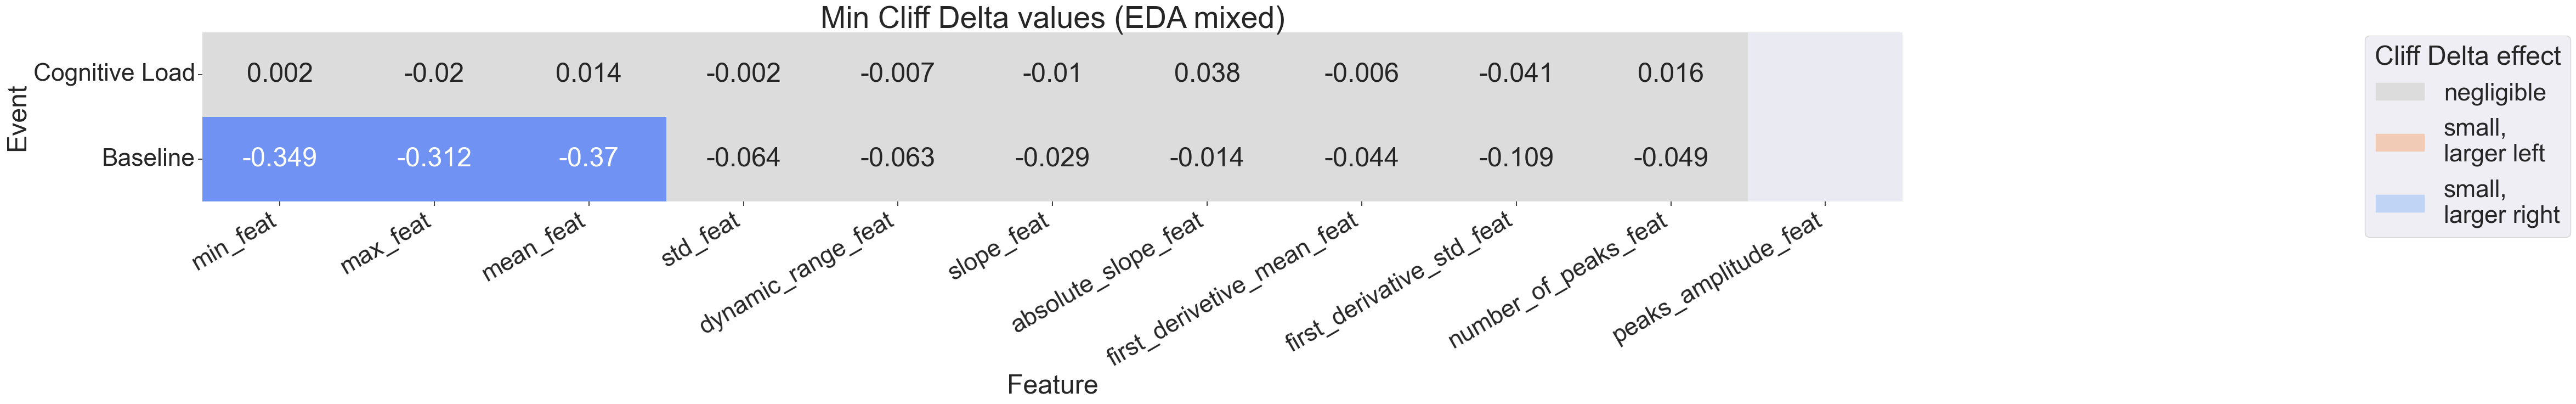

In [41]:
from matplotlib.pyplot import xticks, xlabel, ylabel, legend, cm, figure, title
from matplotlib.patches import Patch
from seaborn import set, heatmap


cmap = cm.coolwarm
set(font_scale=2.9)
figure(figsize=(40, 4))
ax = heatmap(cliff_delta_bins, 
        xticklabels=cliff_deltas_values.columns,
        vmax=3, vmin=-3, center=0,
        annot=cliff_deltas_values.astype(float).round(decimals=3),
        cmap=cmap,
        fmt='',
        cbar=False,
        yticklabels=cliff_deltas_values.index)
ax.tick_params(left=True, bottom=True)
xticks(rotation=30, ha='right')
xlabel('Feature')
ylabel('Event')
title(
    "Min Cliff Delta values (EDA mixed)", fontsize=40
)

custom_handles = [Patch(facecolor=cmap(0.5), edgecolor=cmap(0.5), label='negligible'),
                Patch(facecolor=cmap(0.6), edgecolor=cmap(0.6), label='small,\nlarger left'),
                Patch(facecolor=cmap(0.4), edgecolor=cmap(0.4), label='small,\nlarger right')]
legend(handles=custom_handles, bbox_to_anchor=(1.4, 1.05), title='Cliff Delta effect')
# savefig("../visualizations/cliff_delta_confrontations_eda.pdf",  bbox_inches='tight')
show()